<a href="https://colab.research.google.com/github/MaansAndersson/swallow/blob/master/notebook_grade2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3")
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil
import numpy as np 


dolfin_version = dolfin.__version__
print('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

E: Package 'python-software-properties' has no installation candidate
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
   IPM ite

/usr/lib/python3/dist-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'interactive'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)


to tex
0.3 & 0.20 & 3.71e-04 & 2.25e-03 & 2.45e-03 & 8.7006 & 190.822 & 191.848 & 193.854 \\


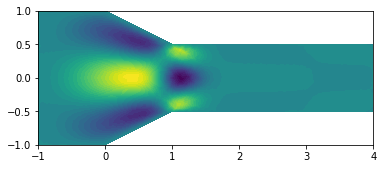

In [3]:
"""This program solves the grade-two non-Newtonian fluid model equations
in an expanding duct with Dirichlet boundary conditions given by 
u=(1-y^2,0) on the left,  u = (0.5(1-0.25*y^2),0) on the right and
u=0 elsewhere.
The boundary conditions for z are posed only on the inflow boundary
"""
from mshr import *
from dolfin import *
import math,sys

set_log_active(False)

meshsize=32
reno=0.3
alfa=0.2
#rbufr=float(sys.argv[4])

realf=reno*alfa

upright=0.5
right=1.0
lbufr=-1.0
rbufr=3.0
fudg=10000
pdeg=4

# create mesh and define velocity and pressure function spaces 
domain =  Polygon([dolfin.Point(lbufr, -1.0),\
                   dolfin.Point( 0.0, -1.0),\
                   dolfin.Point(right, -upright),\
                   dolfin.Point(right+rbufr, -upright),\
                   dolfin.Point(right+rbufr,  upright),\
                   dolfin.Point(right,  upright),\
                   dolfin.Point(0.0,  1.0),\
                   dolfin.Point(lbufr,  1.0)])

def in_bdry(x):
  return x[0] < lbufr+DOLFIN_EPS
  
def calculate_pressure_drop(p_in, V, mesh):
# Outline for pressure drop calculations
  p = project(p_in, FunctionSpace(mesh, "Lagrange", pdeg - 1))

  # Analytical velocity profile and approximated "marker function"
  velocity_in = interpolate(Expression(("(0.5*(1+tanh(K*(-x[0]))))*-x[0]/(2*bi)","0"), K = 1000, bi = lbufr, degree=4), V)
  velocity_out = interpolate(Expression(("(0.5*(1+tanh(K*(x[0]-L))))*(x[0]-L)/(2*H*b0)","0"), K = 1000, L = 1.0, H = 0.5, b0 = rbufr, degree=4), V)


  p_avg_in_form = div(velocity_in*p)*dx(mesh)
  p_avg_in = assemble(p_avg_in_form)
  #print('p_in: ', p_avg_in)

  p_avg_out_form = div(velocity_out*p)*dx(mesh)
  p_avg_out = assemble(p_avg_out_form)
  #print('p_out: ', p_avg_out)

  #print('p_delta: ', p_avg_in-p_avg_out,'\n')
  return p_avg_in-p_avg_out

# Create mesh and define function space
mesh   = generate_mesh(domain, meshsize)
newmesh = refine(mesh)
newmesh = refine(newmesh)
W = VectorFunctionSpace(newmesh, "Lagrange", 1)

V = VectorFunctionSpace(mesh, "Lagrange", pdeg)
Z = FunctionSpace(mesh, "Lagrange", pdeg)
# define boundary condition
boundary_exp = Expression(("exp(-fu*(lb-x[0])*(lb-x[0]))*(1.0-x[1]*x[1]) + \
  (1.0/up)*exp(-fu*(ri+rb-x[0])*(ri+rb-x[0]))*(1.0-((x[1]*x[1])/(up*up)))","0"), \
                   up=upright,ri=right,fu=fudg,rb=rbufr,lb=lbufr,degree = pdeg)
boundary_zee = Expression("exp(-fu*(lb-x[0])*(lb-x[0]))*(2.0*x[1]) + \
           exp(-fu*(ri+rb-x[0])*(ri+rb-x[0]))*(2.0*x[1]/(up*up*up))", \
                   up=upright,ri=right,fu=fudg,rb=rbufr,lb=lbufr,degree = pdeg)
#boundary_zee = Expression("0.0")

bc = DirichletBC(V, boundary_exp, "on_boundary")
bczee = DirichletBC(Z, boundary_zee, in_bdry)
# set the parameters
zf = Expression(("0","0"),degree = pdeg)
bcz = DirichletBC(V, zf, "on_boundary")
r = 1.0e4

# define test and trial functions, and function that is updated
uold = TrialFunction(V)
gold = TrialFunction(V)
zee = TrialFunction(Z)
v = TestFunction(V)
w = Function(V)
w=project(zf,V)
asf = inner(grad(uold), grad(v))*dx + r*div(uold)*div(v)*dx 
asg = (inner(grad(gold),grad(v))             \
       +r*div(gold)*div(v))*dx
bs = -div(w)*div(v)*dx
uold = Function(V)
ust = Function(V)
pdes = LinearVariationalProblem(asf, bs, uold, bc)
solvers = LinearVariationalSolver(pdes)


# Stokes solution
# Scott-Vogelius iterated penalty method
iters = 0; max_iters = 5; div_u_norm = 1
while iters < max_iters and div_u_norm > 1e-10:
# solve and update w
    solvers.solve()
    w.vector().axpy(r, uold.vector())
# find the L^2 norm of div(u) to check stopping condition
    div_u_norm = sqrt(assemble(div(uold)*div(uold)*dx(mesh)))
    print( "   IPM iter_no=",iters,"div_u_norm="," %.5e"%div_u_norm)
    iters += 1
print( "Stokes solver  IPM iter_no=",iters,"div_u_norm="," %.2e"%div_u_norm)
pstoke = calculate_pressure_drop(-div(w)/reno, V, mesh)

uold.set_allow_extrapolation(True)
seeu=interpolate(uold,W)
ust.vector().axpy(1.0, uold.vector())


# ust is the Stokes solution
# Navier-Stokes solver
kters = 0; max_kters = 9; unorm = 1
while kters < max_kters and unorm > 1e-6:
    u = TrialFunction(V)
    v = TestFunction(V)
    w = Function(V)
    w=project(zf,V)

    a = inner(grad(u), grad(v))*dx + r*div(u)*div(v)*dx \
      +reno*inner(grad(uold)*u,v)*dx+reno*inner(grad(u)*uold,v)*dx 
    b = -div(w)*div(v)*dx
    F = inner(grad(uold), grad(v))*dx+reno*inner(grad(uold)*uold,v)*dx

    u = Function(V)
    pde = LinearVariationalProblem(a, F + b, u, bcz)
    solver = LinearVariationalSolver(pde)
  # Scott-Vogelius iterated penalty method
    iters = 0; max_iters = 10; div_u_norm = 1
    while iters < max_iters and div_u_norm > 1e-10:
        # solve and update w
        solver.solve()
        w.vector().axpy(r, u.vector())
        # find the L^2 norm of div(u) to check stopping condition
        div_u_norm = sqrt(assemble(div(u)*div(u)*dx(mesh)))
        print( "   IPM iter_no=",iters,"div_u_norm="," %.2e"%div_u_norm)
        iters += 1
    print( "   IPM iter_no=",iters,"div_u_norm="," %.2e"%div_u_norm)
    kters += 1
    uold.vector().axpy(-1.0, u.vector())
    unorm=norm(u,norm_type='H1')
    uoldnorm=norm(uold,norm_type='H1')
    div_u_norm = sqrt(assemble(div(uold)*div(uold)*dx(mesh)))
    print( "Newton iter_no=",kters,"Delta_u_norm="," %.2e"%unorm,"u_norm=", \
          " %.2e"%uoldnorm,"div_u_norm="," %.2e"%div_u_norm)

# Extract pressure
uz = TrialFunction(V)
v = TestFunction(V)
w = Function(V)
w = project(zf,V)

ap = inner(grad(uz), grad(v))*dx + r*div(uz)*div(v)*dx
b = -div(w)*div(v)*dx
Fp = -reno*inner(grad(uold)*uold,v)*dx

iter = 0
div_u_norm = 1
uz = Function(V)
pdep = LinearVariationalProblem(ap, Fp + b, uz, bc)
solvep = LinearVariationalSolver(pdep)
while(iter < max_iters and div_u_norm > 1e-10):
    solvep.solve()
    w.vector().axpy(r, uz.vector())
    iter += 1
    div_u_norm = sqrt(assemble(div(uz)*div(uz)*dx(mesh)))

pnse = calculate_pressure_drop(-1/reno*div(w), V, mesh)


#plot(uold[0], interactive=True)
nst = Function(V)
# nst is the Navier-Stokes solution
nst.vector().axpy(1.0, uz.vector())
gold = Function(V)
gold.vector().axpy(1.0, uz.vector())
# Grade-two solver
gters = 0; max_gters = 20; incrgoldnorm = 1
errfn = Function(V)
goldr = Function(V)
gtol=alfa*0.0001
while gters < max_gters and incrgoldnorm > gtol:
    wg = Function(V)
    zee = Function(Z)
    dub = TestFunction(Z)

    ZF =(zee*dub + realf*inner(gold,grad(zee))*dub-(grad(gold[1])[0]-grad(gold[0])[1])*dub)*dx
    solve(ZF == 0,zee,bczee)
    
    FF = reno*zee*(v[0]*gold[1]-v[1]*gold[0])*dx
    bg = -div(wg)*div(v)*dx
    pdegt = LinearVariationalProblem(asg, FF + bg, gold, bc)
    solverg = LinearVariationalSolver(pdegt)
    
    iters = 0; max_iters = 5; div_u_norm = 1
    while iters < max_iters and div_u_norm > 1e-10:
        # solve and update wg
        solverg.solve()
        wg.vector().axpy(r, gold.vector())
        # find the L^2 norm of div(u) to check stopping condition
        div_u_norm = sqrt(assemble(div(gold)*div(gold)*dx(mesh)))
        iters += 1
    #plot(div(uold), interactive=True)
    print( "   IPM iter_no=",iters,"div_u_norm="," %.2e"%div_u_norm)
    incrgoldnorm=errornorm(gold,goldr,norm_type='H1',degree_rise=2)/norm(gold,norm_type='H1')
    print( gters,"change="," %.3e"%incrgoldnorm)
    gters += 1
    goldr = Function(V)
    goldr.vector().axpy(1, gold.vector())


# compare Stokes with grade-two
goldnorm=norm(ust,norm_type='H1')
stomingtoonorm=errornorm(gold,ust,norm_type='H1')/goldnorm
stominavstorm=errornorm(nst,ust,norm_type='H1')/goldnorm

# compare Navier-Stokes with grade-two
gold.vector().axpy(-1.0, nst.vector())
goldnstnorm=norm(gold,norm_type='H1')/goldnorm

# Calculate Grade two pressure
u_in = goldr
A = 2*sym(grad(u_in))
p_in = -div(wg)/reno + (- 0.5*inner(u_in,u_in) + alfa*(dot(u_in,div(grad(u_in))) + 0.25*inner(A,A)))
pg = calculate_pressure_drop(p_in, V, mesh)


print( "z_BC's upr","lbuf","rbuf","MS","Re_no"," alpha ","  NSt-Gtu","  Sto-Gtu","  NSt-Sto"," gits", \
      "G2_it_err","|Stokes|","|z|_L2")
print( "inflow ",upright,lbufr,rbufr,meshsize,"%.1f"%reno," %.2e"%alfa," %.2e"%goldnstnorm, \
       " %.2e"%stomingtoonorm, " %.2e"%stominavstorm,"  ",gters,"   %.1e"%incrgoldnorm, \
       " %.4f"%goldnorm," %.4f"%norm(zee,norm_type='L2'))

plot(gold[0], interactive=True)

# compare Navier-Stokes with Stokes
#uold.vector().axpy(-1.0, ust.vector())
#plot(uold[0], interactive=True)
#uold.set_allow_extrapolation(True)
#seeu=interpolate(uold,W)
#plot(seeu[0], interactive=True)
#plot(seeu[1], interactive=True)
#plot(seeu, interactive=True)
#plot(u[0], interactive=True, wireframe=True)
#plot(u, interactive=True)
# Ultimate Stokes Algorithm (USA)
#p_US = project(div(w), FunctionSpace(mesh, "Lagrange", pdeg - 1))

print('to tex')
print("%.1f"%reno,"& %.2f"%alfa,"& %.2e"%goldnstnorm, \
"& %.2e"%stomingtoonorm, "& %.2e"%stominavstorm, \
"& %.4f"%norm(zee,norm_type='L2'),"& %.3f"%pstoke,"& %.3f"%pnse,"& %.3f"%pg, "\\\\")


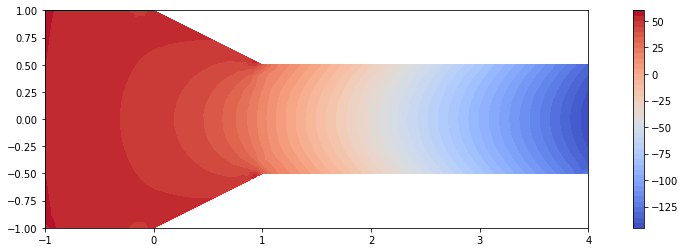

In [6]:
# check if sane for NSE
fig = plt.gcf(); fig.set_size_inches(16, 4)
c = plot(p_in, cmap="coolwarm")
plt.colorbar(c)


Calling FFC just-in-time (JIT) compiler, this may take some time.


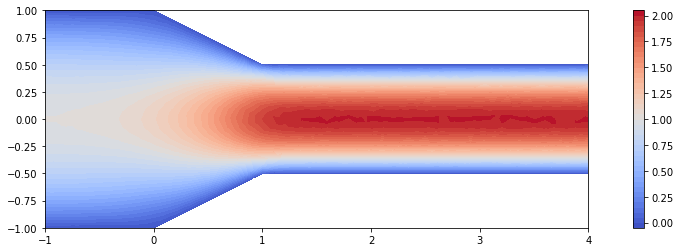

In [5]:
fig = plt.gcf(); fig.set_size_inches(16, 4)
c = plot(sqrt(inner(goldr,goldr)), cmap="coolwarm")
plt.colorbar(c)